<font color='cadetblue'>Validation is provided for easy integrations in your meta-models.</font>

# <p style="font-size:28px; background-color:cadetblue; text-align:center; vertical-align: middle; padding:20px 0;">Imports</p>

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

# <p style="font-size:28px; background-color:cadetblue; text-align:center; vertical-align: middle; padding:20px 0;">Data Loading</p>

In [2]:
data_dir = Path("C:/Users/ys726/Desktop/Crab_Age_Dataset")
train = pd.read_csv("C:/Users/ys726/Desktop/Crab_Age_Dataset/train/train.csv")
test = pd.read_csv("C:/Users/ys726/Desktop/Crab_Age_Dataset/test/test.csv")

submission = pd.read_csv(data_dir/'sample_submission.csv')

target = 'Age'

# <p style="font-size:28px; background-color:cadetblue; text-align:center; vertical-align: middle; padding:20px 0;">Exploratory Data Analysis</p>

## First glance

In [3]:
display(train.head())
features = train.columns.drop([target, 'id']).to_list()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


## Shapes

In [4]:
print(f'Train\'s shape: {train.shape}')
print(f'Test\'s shape: {test.shape}')

Train's shape: (74051, 10)
Test's shape: (49368, 9)


## Target

In [5]:
print(f'{target}\'s type: {train[target].dtype}')
print(f'Interval: [{np.min(train[target])}, {np.max(train[target])}]')

Age's type: int64
Interval: [1, 29]


The target column is of type Integer between 1 and 29.

### Target's boxplot and histogram

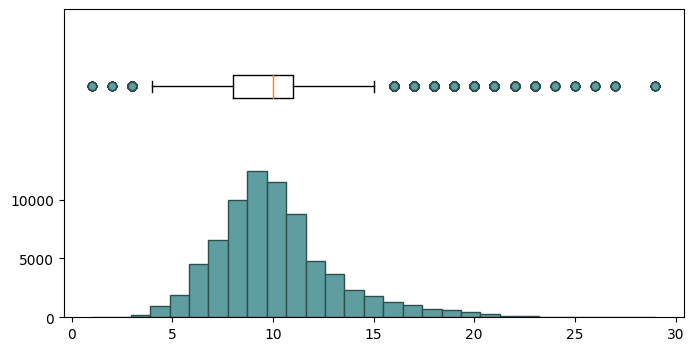

In [6]:
fig, [top, bottom] = plt.subplots(2, 1, figsize=(8,4))
plt.subplots_adjust(hspace=0)

flierprops = dict(marker='o', markerfacecolor='cadetblue', markeredgecolor='darkslategray', markersize=6)
top.boxplot(x=train[target], flierprops=flierprops, vert=False)
top.spines.bottom.set_visible(False)
top.set_xticks([])
top.set_yticks([])

bottom.hist(x=train[target], color='cadetblue',edgecolor='darkslategray', bins=29)
bottom.spines.top.set_visible(False)
plt.show()

## Feature Info

In [7]:
train[features].info()
categorical_features = ['Sex']
numerical_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             74051 non-null  object 
 1   Length          74051 non-null  float64
 2   Diameter        74051 non-null  float64
 3   Height          74051 non-null  float64
 4   Weight          74051 non-null  float64
 5   Shucked Weight  74051 non-null  float64
 6   Viscera Weight  74051 non-null  float64
 7   Shell Weight    74051 non-null  float64
dtypes: float64(7), object(1)
memory usage: 4.5+ MB


No NAs in this dataset.

## Categorical feature (Sex)

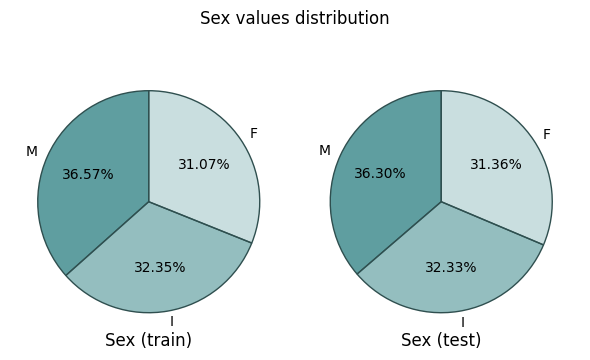

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(6,4))

for ax, df, label in zip(axes, [train, test], ['train', 'test']):
    data = df['Sex'].value_counts(normalize=True)
    n_classes = df['Sex'].nunique()

    colors = []
    for alpha in np.arange(n_classes, 0, -1)/n_classes:
        colors.append(plt_colors.to_rgba('cadetblue', alpha=alpha))

    ax.pie(data, labels=data.index, autopct='%.2f%%', colors=colors, startangle=90, wedgeprops={'edgecolor':'darkslategray','linewidth': 1})
    ax.set_title(f'Sex ({label})', y=-.05)


fig.tight_layout()
fig.suptitle('Sex values distribution', fontsize=12)
plt.show()

## Spread of 'Age' per 'Sex' groups

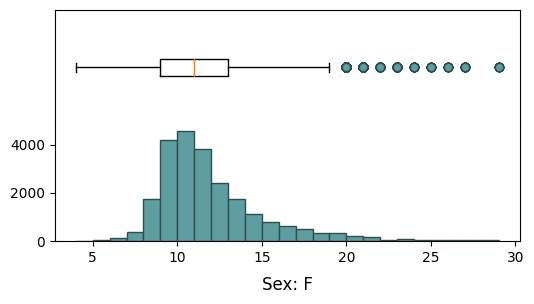

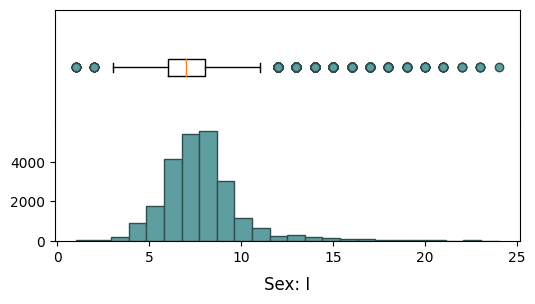

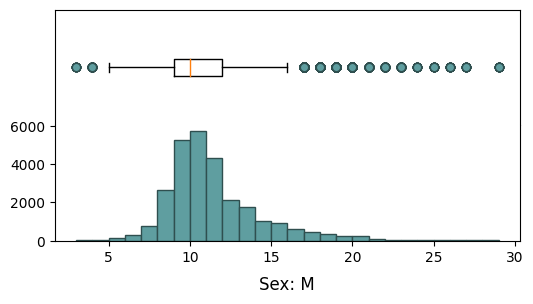

In [9]:
for name, group in train.groupby(by='Sex')[target]:

    fig, [top, bottom] = plt.subplots(2, 1, figsize=(6,3))
    plt.subplots_adjust(hspace=0)
    
    
    top.boxplot(x=group, flierprops=flierprops, vert=False)
    
    top.spines.bottom.set_visible(False)
    top.set_xticks([])
    top.set_yticks([])

    bottom.hist(x=group, color='cadetblue',edgecolor='darkslategray', bins=group.nunique())
    bottom.spines.top.set_visible(False)
    bottom.set_title(f'Sex: {name}', y=-.5)

    plt.show()
    

## Numerical features boxplots

Check out 'Length' for annotations

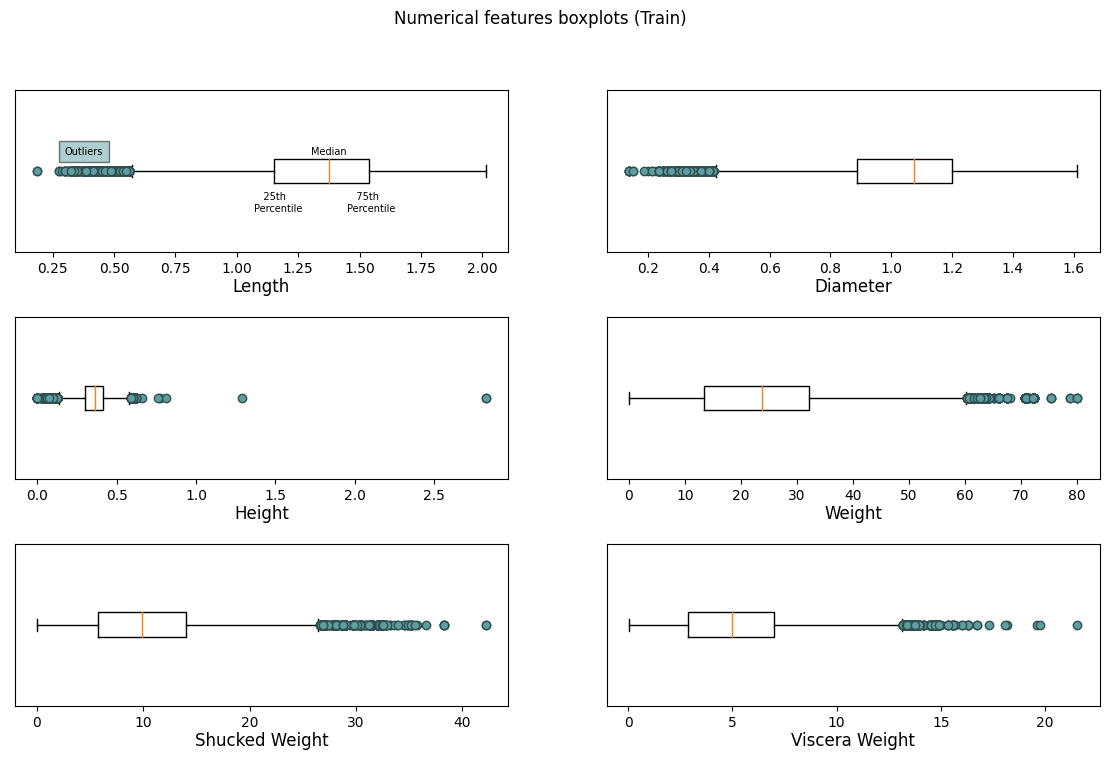

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.4)


for ax, numerical_feature in zip(axes.reshape(-1), numerical_features):
    ax.boxplot(x=train[numerical_feature], flierprops=flierprops, vert=False)
    ax.set_title(numerical_feature, y=-.3)
    ax.set_yticks([])

# Annotate the first boxplots for better interpretation
axes[0, 0].text(.3, 1.1, 'Outliers', bbox=dict(facecolor='cadetblue', alpha=0.5), fontsize=7)
axes[0, 0].text(1.07, .75, '   25th\nPercentile', fontsize=7)
axes[0, 0].text(1.3, 1.1, 'Median', fontsize=7)
axes[0, 0].text(1.45, .75, '   75th\nPercentile', fontsize=7)

fig.suptitle('Numerical features boxplots (Train)', fontsize=12)
plt.show()

## Feature corrolations

In [11]:
corr = train.drop(categorical_features+['id'], axis=1).corr()
corr.style.background_gradient(cmap='PuBuGn').format(precision=3)

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
Length,1.000,0.989,0.918,0.936,0.916,0.918,0.917,0.613
Diameter,0.989,1.000,0.921,0.938,0.914,0.918,0.923,0.621
Height,0.918,0.921,1.000,0.902,0.864,0.883,0.903,0.638
Weight,0.936,0.938,0.902,1.000,0.971,0.971,0.966,0.601
Shucked Weight,0.916,0.914,0.864,0.971,1.000,0.943,0.910,0.503
Viscera Weight,0.918,0.918,0.883,0.971,0.943,1.000,0.934,0.577
Shell Weight,0.917,0.923,0.903,0.966,0.910,0.934,1.000,0.663
Age,0.613,0.621,0.638,0.601,0.503,0.577,0.663,1.000


# <p style="font-size:28px; background-color:cadetblue; text-align:center; vertical-align: middle; padding:20px 0;">Data preparation</p>

## Encoding categorical features

In [12]:
enc = OneHotEncoder() 
ohe_train = pd.DataFrame(enc.fit_transform(train[categorical_features]).toarray(), columns=enc.get_feature_names_out())
train.drop(categorical_features, axis=1, inplace=True)
train = pd.concat([train, ohe_train], axis=1)

ohe_test = pd.DataFrame(enc.transform(test[categorical_features]).toarray(), columns=enc.get_feature_names_out())
test.drop(categorical_features, axis=1, inplace=True)
test = pd.concat([test, ohe_test], axis=1)

features = train.columns.drop(['id', target]).to_list()

## Split datasets for training

In [13]:
y_train = train[target]
train = train[features]
test = test[features]

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our model</h2>

In [14]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), train, y_train, cv=cv)

array([0.55053208, 0.54583793, 0.55154168, 0.55385934, 0.54946329])

<h2 style='color:black; text-align:center; background-color:orange; padding:20px 0'> Find best model using GridSearchCV </h2>

In [15]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {'model': LinearRegression(),
                               'params': {'n_jobs': [-1]}},

        'lasso': {'model': Lasso(), 
                  'params': {'alpha': [1e-5, 1e-4, 1e-3], 'selection': ['random', 'cyclic']}},

        'ridge': {'model': Ridge(), 
                  'params': {'alpha': [0.1,1,2]}},
        
        'catboost' : {}
            }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [16]:
find_best_model_using_gridsearchcv(train,y_train)

C:\Users\ys726\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.759e+04, tolerance: 5.970e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\ys726\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.087e+04, tolerance: 5.991e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\ys726\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\loca

,model,best_score,best_params
0,linear_regression,0.550247,{'n_jobs': -1}
1,lasso,0.550263,"{'alpha': 0.0001, 'selection': 'random'}"
2,ridge,0.550268,{'alpha': 2}


In [17]:
model = Ridge(alpha=0.1)

#Aplly model on train dataset
model.fit(train, y_train)

#model score on train dataset
print(f'Score {model.score(train, y_train)}')

#predicted value of train and test dataset
validation = model.predict(train)

lr_train_mse  = mean_absolute_error((y_train), (validation))
print("Train MSE :" , round(lr_train_mse,5))

Score 0.5508242979514649
Train MSE : 1.48223


In [18]:
#Aplly model on test dataset
y_hat_test = model.predict(test)
y_hat_test

array([ 7.73534097,  7.68248305, 10.43298569, ..., 12.3314911 ,
       10.02427442, 12.6266088 ])

### y_train VS ŷ_train

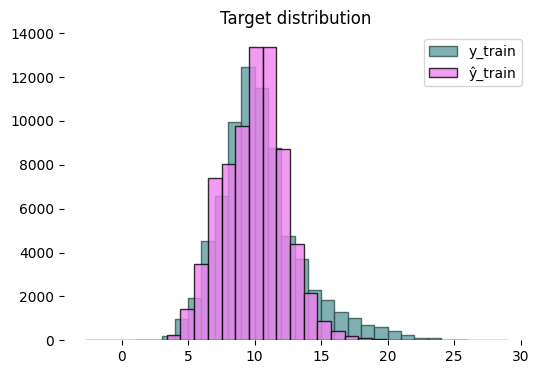

In [19]:
plt.figure(figsize=(6,4))
ax = plt.gca()
plt.title('Target distribution')

for spine in ax.spines.values():
    spine.set_visible(False)

ax.hist(x=y_train, color='cadetblue',edgecolor='darkslategray',alpha=.8, bins=y_train.nunique(), label='y_train')
ax.hist(x=validation, color='violet',edgecolor='black',alpha=.8, bins=y_train.nunique(), label='ŷ_train')
ax.legend()

plt.show()

# <p style="font-size:28px; background-color:cadetblue; text-align:center; vertical-align: middle; padding:20px 0;">Submission</p>

## Serialization

In [20]:
# Assuming `validation` is a NumPy array
validation = np.round(validation).astype(int)

# Create a pandas DataFrame from the vertical array
validation_df = pd.DataFrame(validation.transpose(), columns=['Age'])

# Save the DataFrame to a CSV file
validation_df.to_csv('validation.csv', index=False)


In [21]:
submission[target] = np.round(y_hat_test).astype(int)
submission.to_csv('yaman_submission.csv', index=False)